# Age Estimation 

In [ ]:
import numpy as np
import os
from math import * 
from helperP import *

# Loading Data

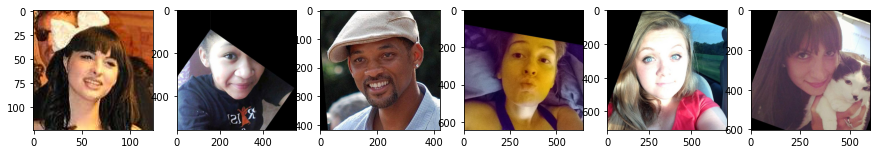

In [4]:
base_dir = 'DATASET/'

age_train, features_train = prepare_data('train', base_dir)
age_val, features_val = prepare_data('val', base_dir)
_, features_test = prepare_data('test', base_dir)
show_data(base_dir)


## Linear class
	LINEAR
	Implementation of the linear layer (also called fully connected layer)
	which performs linear transoformation on input data y = xW + b.
	This layer has two learnable parameters, weight of shape (input_channel, output_channel)
	and bias of shape (output_channel), which are specified and initalized in init_param()
	function. In this assignment, you need to implement both forward and backward computation
	Arguments:
		input_channel  -- integer, number of input channels
		output_channel -- integer, number of output channels

In [ ]:
class Linear(object):

	def __init__(self, input_channel, output_channel):
		self.input_channel = input_channel
		self.output_channel = output_channel
		self.init_param()

	def init_param(self):
		##################################################
		# TODO: YOUR CODE HERE: init weights
		##################################################
		d = np.sqrt((self.input_channel + self.output_channel) / 2)
		self.weight = np.random.randn(self.input_channel, self.output_channel) / d
		self.bias = np.zeros(self.output_channel)

	'''
		Forward computation of linear layer, you may want to save some intermediate
		variable to class membership (self.) for reusing in backward computation.
		Arguments:
			input -- numpy array of shape (N, input_channel)

		Output:
			output -- numpy array of shape (N, output_channel)
	'''
	def forward(self, input):
		self.input = input
		##################################################
		# TODO: YOUR CODE HERE: forward
		##################################################
		output = np.dot(self.input, self.weight) + self.bias
		return output

	'''
		Backward computation of linear layer, you need to compute the gradient
		w.r.t input, weight and bias respectively. You need to reuse the variable in forward
		computation to compute backward gradient.

		Arguments:
			grad_output -- numpy array of shape (N, output_channel)

		Output:
			grad_input -- numpy array of shape (N, input_channel), gradient w.r.t input
			grad_weight -- numpy array of shape (input_channel, output_channel), gradient w.r.t weight
			grad_bias --  numpy array of shape (output_channel), gradient w.r.t bias
	'''
	def backward(self, grad_output):
		##################################################
		# TODO: YOUR CODE HERE: backward
		##################################################
		grad_bias = np.sum(grad_output, axis=0)
		grad_weight = np.dot(self.input.T, grad_output)
		grad_input = np.dot(grad_output, self.weight.T)
		return grad_input, grad_weight, grad_bias

## CROSS_ENTROPY_LOSS_WITH_SOFTMAX
	Implementation of the combination of softmax function and cross entropy loss.
	In classification task, we usually firstly apply softmax to map class-wise prediciton
	into the probabiltiy distribution then we use cross entropy loss to maximise the likelihood
	of ground truth class's prediction. Since softmax includes exponential term and cross entropy includes
	log term, we can simplify the formula by combining these two functions togther so that log and exp term could cancell out
	mathmatically and we can avoid precision lost with float point numerical computation.
	If we ignore the index on batch sizel and assume there is only one grouth truth per sample,
	the formula for softmax and cross entropy loss are:
		Softmax: prob[i] = exp(x[i]) / \sum_{j}exp(x[j])
		Cross_entropy_loss:  - 1 * log(prob[gt_class])
	Combining these two function togther, we got
		cross_entropy_with_softmax: -x[gt_class] + log(\sum_{j}exp(x[j]))
	In this assignment, you will implement both forward and backward computation.
	Arguments:
		None

In [ ]:
class CrossEntropyLossWithSoftmax(object):
	def __init__(self):
		pass
	'''
		Forward computation of cross entropy with softmax, you may want to save some intermediate variables to class membership (self.)
		Arguments:
			input    -- numpy array of shape (N, C), the prediction for each class, where C is number of class
			gt_label -- numpy array of shape (N), it's a integer array and the value range from 0 to C-1 which
						specify the ground truth class for each input
		Output:
			output   -- numpy array of shape (N), containing the cross entropy loss on each input
	'''
	def forward(self, input, gt_label):
		##################################################
		# TODO: YOUR CODE HERE: forward
		##################################################
		self.N = range(input.shape[0])
		self.gt_label = gt_label
		exp = np.exp(input)
		self.prob = exp / np.sum(exp, axis=1)[:, None]
		output = - 1 * np.log(self.prob[self.N, gt_label])
		return output

	'''
		Backward computation of cross entropy with softmax. It's recommended to resue the variable
		in forward computation to simplify the formula.
		Arguments:
			grad_output -- numpy array of shape (N)

		Output:
			grad_input  -- numpy array of shape (N, C), the gradient w.r.t input of forward function
	'''
	def backward(self, grad_output):
		##################################################
		# TODO: YOUR CODE HERE: backward
		##################################################
		grad_input = np.copy(self.prob)
		grad_input[self.N, self.gt_label] -= 1
		return grad_input

## RELU
	Implementation of relu (rectified linear unit) layer. Relu is the no-linear activating function that
	set all negative values to zero and the formua is y = max(x,0).
	This layer has no learnable parameters and you need to implement both forward and backward computation
	Arguments:
		None

In [ ]:
class ReLU(object):
	def __init__(self):
		pass
	'''
		Forward computation of relu and you may want to save some intermediate variables to class membership (self.)
		Arguments:
			input -- numpy array of arbitrary shape

		Output:
			output -- numpy array having the same shape as input.
	'''
	def forward(self, input):
		self.input = input
		##################################################
		# TODO: YOUR CODE HERE: forward
		##################################################
		output = np.maximum(self.input, 0)
		return output

	'''
		Backward computation of relu, you can either in-place modify the grad_output or create a copy.
		Arguments:
			grad_output-- numpy array having the same shape as input

		Output:
			grad_input -- numpy array has the same shape as grad_output. gradient w.r.t input
	'''
	def backward(self, grad_output):
		##################################################
		# TODO: YOUR CODE HERE: backward
		##################################################
		grad_input = np.copy(grad_output)
		grad_input[self.input < 0] = 0
		return grad_input

# Implement Stochastic Gradient descent
Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning.
```
Arguments:
    age          -- numpy array, label, (n, )
    feature      -- numpy array, features, (n, 2048)
Return:
    weights      -- numpy array, (2048, )
    bias         -- numpy array, (1, )
```

In [ ]:
def stochastic_gradient_descent(age, feature, age_val, feature_val):
    # check the inputs
    assert len(age) == len(feature)

    # Set the random seed
    np.random.seed(0)
    
    # Set the learning rate
    lr = 1e-3
    
    # Set the momentum term
    alpha = 0.9    
    
    # Set the hidden layers (You can tune this parameter for better performance)
    num_lat = 128

    # Define the net with the python layers
    fc0 = Linear(2048, num_lat)
    relu0 = ReLU()
    fc1 = Linear(num_lat,101)
    model = [fc0, relu0, fc1]
    cretirion = CrossEntropyLossWithSoftmax()

    # Initialize parameters of the layers
    fc0.init_param()
    fc1.init_param()

    # Number of mini-batches
    t = len(age) // batch_size

    # Optimal weights and loss for val
    model_opt = {'fc0_weight': fc0.weight, 'fc0_bias' : fc0.bias,
           'fc1_weight': fc1.weight, 'fc1_bias'  : fc1.bias}
    loss_opt = 1e6
    
    # Initialize the descent direction
    v = {'fc0_weight': np.zeros_like(fc0.weight), 'fc0_bias' : np.zeros_like(fc0.bias),
         'fc1_weight': np.zeros_like(fc1.weight), 'fc1_bias' : np.zeros_like(fc1.bias)}
    
    for e in range(epoch_sgd):
        # Shuffle training data
        n = np.random.permutation(len(feature))

        loss_train = []
        for m in range(t):
            # Providing mini batch with fixed batch size of 16
            batch_feature = feature[n[m * batch_size: (m + 1) * batch_size]]
            batch_age = age[n[m * batch_size: (m + 1) * batch_size]].reshape(-1, 1).astype(np.int16).squeeze()

            ##########################################################################
            # TODO: YOUR CODE HERE
            ##########################################################################
            # forward pass (loss is the average of the cross entropy loss for all samples)
            z1 = fc0.forward(batch_feature)
            a1 = relu0.forward(z1)
            z2 = fc1.forward(a1)
            ce = cretirion.forward(z2, batch_age)
            # loss at the end of the function 'stochastic_gradient_descent'
            loss_train.append(ce)
            
            ##########################################################################
            # TODO: YOUR CODE HERE
            ##########################################################################
            # calculate gradient here
            dz2 = cretirion.backward(np.ones_like(ce))
            da1, dw1, db1 = fc1.backward(dz2)
            dz1 = relu0.backward(da1)
            dinput, dw0, db0 = fc0.backward(dz1)

            ##########################################################################
            # TODO: YOUR CODE HERE
            ##########################################################################               
            # calculate the gradient with momentum and record it in v
            # momentum term is given by alpha              
            v['fc0_weight'] = alpha * v['fc0_weight'] + lr * dw0
            v['fc0_bias']   = alpha * v['fc0_bias']   + lr * db0
            v['fc1_weight'] = alpha * v['fc1_weight'] + lr * dw1
            v['fc1_bias']   = alpha * v['fc1_bias']   + lr * db1
            
            ##########################################################################
            # 
            ##########################################################################                
            # update the parameters
            fc0.weight -= v['fc0_weight']
            fc0.bias   -= v['fc0_bias']
            fc1.weight -= v['fc1_weight']
            fc1.bias   -= v['fc1_bias']

        ##########################################################################
        # TODO: YOUR CODE HERE
        ##########################################################################                 
        # calculate the mean absolute error on validation set
        pred_val = np.dot(feature_val, fc0.weight) + fc0.bias
        pred_val = relu0.forward(pred_val)
        pred_val = predict(fc1.weight, fc1.bias, pred_val)
        loss_val = np.abs(pred_val - age_val).mean()

        ##########################################################################
        # TODO: YOUR CODE HERE
        ##########################################################################  
        # update the optimal model w.r.t. the error
        if (loss_opt > loss_val):
            print('updated:')
            loss_opt = loss_val
            # Store the parameters into the dictionary of model_opt
            model_opt['fc0_weight'] = fc0.weight
            model_opt['fc0_bias']   = fc0.bias
            model_opt['fc1_weight'] = fc1.weight
            model_opt['fc1_bias']   = fc1.bias

        # loss on training set
        loss = np.mean(loss_train)
        print('=> epoch:', e + 1, ' Validation MAE Loss:', round(loss_val, 4), 'Training Loss:', round(loss, 4))
    return model_opt

# Train and validate

updated:
=> epoch: 1  Validation MAE Loss: 5.365 Training Loss: 3.2236
updated:
=> epoch: 2  Validation MAE Loss: 5.174 Training Loss: 2.8096
updated:
=> epoch: 3  Validation MAE Loss: 5.062 Training Loss: 2.7685
=> epoch: 4  Validation MAE Loss: 5.2411 Training Loss: 2.7523
=> epoch: 5  Validation MAE Loss: 5.1251 Training Loss: 2.7533
updated:
=> epoch: 6  Validation MAE Loss: 4.9159 Training Loss: 2.7386
=> epoch: 7  Validation MAE Loss: 4.9529 Training Loss: 2.7293
=> epoch: 8  Validation MAE Loss: 5.043 Training Loss: 2.7191
=> epoch: 9  Validation MAE Loss: 5.0707 Training Loss: 2.7058
updated:
=> epoch: 10  Validation MAE Loss: 4.858 Training Loss: 2.7018
=> epoch: 11  Validation MAE Loss: 4.91 Training Loss: 2.7039
updated:
=> epoch: 12  Validation MAE Loss: 4.8268 Training Loss: 2.7105
=> epoch: 13  Validation MAE Loss: 4.9941 Training Loss: 2.6907
=> epoch: 14  Validation MAE Loss: 4.9386 Training Loss: 2.7077
=> epoch: 15  Validation MAE Loss: 5.2129 Training Loss: 2.6855
=>

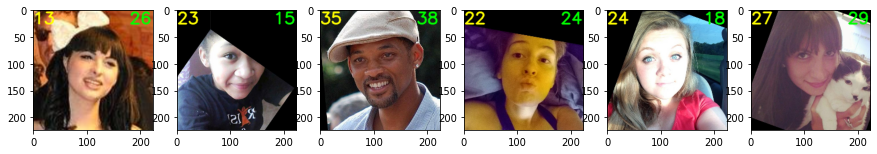

In [9]:
model_opt = stochastic_gradient_descent(age_train, features_train, age_val, features_val)
loss = evaluate_hidden([model_opt['fc0_weight'], model_opt['fc1_weight']], 
                        [model_opt['fc0_bias'],   model_opt['fc1_bias']], 
                        age_val, features_val)
print("Your mean absolute error for validation set is:", round(loss, 3))

# Test and Generate results file

In [10]:
prediction = test_hidden([model_opt['fc0_weight'], model_opt['fc1_weight']], 
            [model_opt['fc0_bias'],   model_opt['fc1_bias']], 
            features_test, filename='sgd_hidden.txt')
print("Test results has saved to sgd_hidden.txt")
print(prediction[:10])

Test results has saved to sgd_hidden.txt
[25.89839713 61.84661932 48.56608961 20.43666436 35.50435033 37.91638699
 49.86001872 40.57458139 22.06398788 58.13926396]
